In [67]:
import numpy as np
import scipy as sp
from math import pi, sqrt
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy.optimize import minimize
import time
from ipywidgets import interact

Essential Fourier functions for the boundaries

In [2]:
def y2(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c= np.exp(1j*k*Ls/2)*(-2j+np.exp(1j*k*Lx)*(2j+ 2*k*Lx- 1j* k**2 * Lx**2))/ (k**3) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**3 /(3*(2*Lx+Ls))
    return c

def y1(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx)*(1- 1j* k * Lx))/ (k**2) /(2*Lx+Ls)
        c[ ~ np.isfinite( c )] = Lx**2 /(2*(2*Lx+Ls))
    return c

def y0(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = -1j*np.exp(1j*k*Ls/2)*(-1+np.exp(1j*k*Lx) )/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Lx /(2*Lx+Ls)
    return c

def y0s(k,Lx,Ls):
    with np.errstate(divide='ignore', invalid='ignore'):
        c = 2*np.sin(k*Ls/2)/(k*(2*Lx+Ls))
        c[ ~ np.isfinite( c )] = Ls /(2*Lx+Ls)
    return c

In [179]:
hbar=1.05e-34
elec=1.6e-19
meV=elec*1e-3

vF=1e6
B=10 # Tesla
hwc=vF*sqrt(2*hbar*elec*B)
lB=np.sqrt(hbar/(elec*B))
# m_sc=3*hwc #1e2*meV
# mu_sc=8*hwc #1e2*meV
D1=0.5*hwc #10*meV
D2=0.6*hwc #10*meV
m_n=0.1*hwc

lRx= 1*hwc
lRy= 0.*hwc
lso= 0.*hwc
# lam=0.5*vF
gs=0.0*hwc
gn=0.2*hwc

sigma0=np.array([[1,0],[0,1]])
sigma1=np.array([[0,1],[1,0]])
sigma2=np.array([[0,-1j],[1j,0]])
sigma3=np.array([[1,0],[0,-1]])
s00=np.kron(sigma0,sigma0)
s30=np.kron(sigma3,sigma0)
s01=np.kron(sigma0,sigma1)
s02=np.kron(sigma0,sigma2)
s03=np.kron(sigma0,sigma3)


def system_E_vs_k(m_sc,mu_sc,mu_n,ky_sw,Nx,Lx,Ls):
    
    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)

    Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
    HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2,Lx,Ls)), sigma2)
    HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1,Lx,Ls)), sigma2)

    Hxm= np.kron( m_sc*y0s(k1-k2,Lx,Ls)+2*m_n*np.real(y0(k1-k2,Lx,Ls)) , sigma3)
    HxmT= np.kron( m_sc*y0s(k2-k1,Lx,Ls)+2*m_n*np.real(y0(k2-k1,Lx,Ls)) , sigma3)
    Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2,Lx,Ls) , lRx*sigma1)) #1
    HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1,Lx,Ls) , lRx*sigma1)) #1
    Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2,Lx,Ls) , lRy*sigma2)) #2
    HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1,Lx,Ls) , lRy*sigma2)) #2
    Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2,Lx,Ls) , lso*sigma3)) # 333
    HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1,Lx,Ls) , lso*sigma3))
    Hl=Hlx+Hly+Hlz
    HlT=HlxT+HlyT+HlzT
    # Hlx=hbar*lam*np.kron(s02, np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
    # HlxT=-hbar*lam*np.kron(s02, np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )

    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2,Lx,Ls)) + mu_sc*y0s(k1-k2,Lx,Ls), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1,Lx,Ls)) + mu_sc*y0s(k2-k1,Lx,Ls), sigma0 )

    Hd= np.kron(y0s(k1-k2,Lx,Ls),sigma0)
    # basis ud,ud
    # dmat1=np.kron(np.array([[0.,1j],[0.,0.]]),sigma1)
    # ddmat1=np.kron(dmat1,sigma2) 
    dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
    ddmat2=np.kron(dmat2,sigma2)
    Hd_mat=np.kron(ddmat2,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

    s03=np.kron(sigma0,sigma3)
    Hz_up= -(gs*y0s(k1-k2,Lx,Ls)+2*gn*np.real(y0(k1-k2,Lx,Ls)))
    Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1,Lx,Ls)+2*gn*np.real(y0(k2-k1,Lx,Ls)))
    HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


    Vn=np.zeros((16*Nx,16*Nx,len(ky_sw)), dtype=np.complex64)
    En=np.zeros((16*Nx,len(ky_sw)))
    for i_y in range(len(ky_sw)):
        ky=ky_sw[i_y]
        Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)

    #     Hly=hbar*lam*ky*np.kron(s01, np.kron(y0s(k1-k2),sigma0) )
    #     HlyT=-hbar*lam*ky*np.kron(s01, np.kron(y0s(k2-k1),sigma0) )

        H1 = Hx + np.kron(s00, Hy+ HeB + Hxm + Hef)+ Hz + Hl
        H1T = -Hx  + np.kron(s00,Hy+ (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

        H_t=block_diag(H1,-H1T)+Hd_mat
#         En[:,i_y], Vn[:,:,i_y] =np.linalg.eigh(H_t)
        En[:,i_y] =np.linalg.eigvalsh(H_t)

    return En


def sample_modes(m_sc,mu_sc,mu_n,Esw,Nx,Lx,Ls,lead_sample):

    kx=2*pi*np.arange(Nx)/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)
    [k1,k2]=2*pi*np.mgrid[range(Nx),range(Nx)]/(2*Lx+Ls)-pi*Nx/(2*Lx+Ls)


    Hx= hbar*vF*np.kron(s30, np.kron(np.diag(kx) , sigma1))
    HeB= 2j*vF*elec*B* np.kron(np.imag(y1(k1-k2,Lx,Ls)), sigma2)
    HeBT= 2j*vF*elec*B* np.kron(np.imag(y1(k2-k1,Lx,Ls)), sigma2)

    Hxm= np.kron( m_sc*y0s(k1-k2,Lx,Ls)+2*m_n*np.real(y0(k1-k2,Lx,Ls)) , sigma3)
    HxmT= np.kron( m_sc*y0s(k2-k1,Lx,Ls)+2*m_n*np.real(y0(k2-k1,Lx,Ls)) , sigma3)
    Hlx= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k1-k2,Lx,Ls) , lRx*sigma1)) #1
    HlxT= np.kron(np.kron(sigma3,sigma2),np.kron( y0s(k2-k1,Lx,Ls) , lRx*sigma1)) #1
    Hly= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k1-k2,Lx,Ls) , lRy*sigma2)) #2
    HlyT= -np.kron(np.kron(sigma0,sigma1),np.kron( y0s(k2-k1,Lx,Ls) , lRy*sigma2)) #2
    Hlz= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k1-k2,Lx,Ls) , lso*sigma3)) # 333
    HlzT= np.kron(np.kron(sigma3,sigma3),np.kron( y0s(k2-k1,Lx,Ls) , lso*sigma3))
    Hl=Hlx+Hly+Hlz
    HlT=HlxT+HlyT+HlzT
    # Hlx=hbar*lam*np.kron(s02, np.kron( (k1+k2)/2*y0s(k1-k2),sigma0) )
    # HlxT=-hbar*lam*np.kron(s02, np.kron((k1+k2)/2*y0s(k2-k1),sigma0) )

    Hef= -np.kron( 2*mu_n*np.real(y0(k1-k2,Lx,Ls)) + mu_sc*y0s(k1-k2,Lx,Ls), sigma0 )
    HefT= -np.kron( 2*mu_n*np.real(y0(k2-k1,Lx,Ls)) + mu_sc*y0s(k2-k1,Lx,Ls), sigma0 )

    Hd= np.kron(y0s(k1-k2,Lx,Ls),sigma0)
    # basis ud,ud
    # dmat1=np.kron(np.array([[0.,1j],[0.,0.]]),sigma1)
    # ddmat1=np.kron(dmat1,sigma2) 
    dmat2=np.kron(np.array([[0.,1j],[0.,0.]]),D1*sigma1+D2*sigma0)
    ddmat2=np.kron(dmat2,sigma2)
    Hd_mat=np.kron(ddmat2,Hd)
    Hd_mat=Hd_mat+np.transpose(Hd_mat).conj()

    s03=np.kron(sigma0,sigma3)
    Hz_up= -(gs*y0s(k1-k2,Lx,Ls)+2*gn*np.real(y0(k1-k2,Lx,Ls)))
    Hz= np.kron(s03, np.kron(Hz_up,sigma0) )
    Hz_upT= -(gs*y0s(k2-k1,Lx,Ls)+2*gn*np.real(y0(k2-k1,Lx,Ls)))
    HzT= np.kron(s03, np.kron(Hz_upT,sigma0) )


#     Hy= hbar*vF*ky*np.kron(np.eye(Nx), sigma2)
    H1 = Hx + np.kron(s00, HeB + Hxm + Hef)+ Hz + Hl
    H1T = -Hx  + np.kron(s00, (HeBT + HxmT + HefT).conj())+ (HzT+HlT).conj()

    H_t=(block_diag(H1,-H1T)+Hd_mat)/(hbar*vF)*lB
  
    kmat=np.kron(sigma3, np.kron(np.eye(4*Nx),sigma2))

    for i_E in range(len(Esw)):
        E=Esw[i_E]/(hbar*vF)*lB

        ky_max = 4
        ky_min = 1e-5
        
        if lead_sample=='lead':            
            evs, evecs = np.linalg.eig( np.dot(kmat,E*(1+1e-2)*np.eye(16*Nx)- H_t ) )
            i_evan= np.where( np.abs(np.imag(evs)) > ky_min )[0]
            ie_T= np.where( np.imag(evs[i_evan]) < 0)[0]
            i_e= i_evan[ie_T]

            i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
            i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
            i_prop3= np.where( np.abs(np.real(evs[i_prop1[i_prop2]])) < ky_max )[0]            
            Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[16*Nx,])
            evecs= np.dot(evecs,np.diag(1/Jmat**0.5))

            ip_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) > 0)[0]
            i_p= i_prop1[i_prop2[i_prop3[ip_T]]]
            Tevecs = evecs[:,i_p]
            
            in_T= np.where( np.real(Jmat[i_prop1[i_prop2]]) < 0)[0]
            i_n= i_prop1[i_prop2[in_T]]
            ptcl= np.sum(np.abs(evecs[:8*Nx,i_n])**2,axis=0)
            hole= np.sum(np.abs(evecs[8*Nx:,i_n])**2,axis=0)
            hz= ptcl-hole
            i_npt= np.where(ptcl-hole > 0)[0]
            i_nhl= np.where(ptcl-hole < 0)[0]
#             num_refl=len(i_n)/2
#             assert num_refl-int(num_refl)~=0, "Number of reflecting modes is %d" % (num_refl)
#             num_refl= int(num_refl)
            num_refl=[len(i_npt),len(i_n)]
            i_neg=np.concatenate((i_n[i_npt],i_n[i_nhl],i_e))
            Revecs = evecs[:,i_neg]

            return num_refl,Revecs,Tevecs
        
        elif lead_sample=='sample':
            evs, evecs = np.linalg.eig( np.dot(kmat,E*np.eye(16*Nx)- H_t ) )
            i_evan= np.where( np.abs(np.imag(evs)) > ky_min )[0]
            ie_T= np.where( np.imag(evs[i_evan]) > 0)[0]
            i_e= i_evan[ie_T]

            i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
            i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
            Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[16*Nx,])
            evecs= np.dot(evecs,np.diag(1/Jmat**0.5))

            ip_T= np.where( np.real(Jmat[i_prop1[i_prop2]]) > 0)[0]
            i_p= i_prop1[i_prop2[ip_T]]
            i_pos=np.concatenate((i_p,i_e))
            Tevecs = evecs[:,i_pos]
            return Tevecs
        else:
            evs, evecs = np.linalg.eig( np.dot(kmat,E*np.eye(16*Nx)- H_t ) )
            i_prop1= np.where( np.abs(np.imag(evs)) < ky_min )[0]
            i_prop2= np.where( np.abs(np.real(evs[i_prop1])) > ky_min )[0]
            i_prop3= np.where( np.abs(np.real(evs[i_prop1[i_prop2]])) < ky_max )[0]            
            Jmat = np.reshape(np.diag(np.dot(np.transpose(evecs).conj(),np.dot(kmat,evecs))),[16*Nx,])
            ip_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) > 0)[0]
            i_p= i_prop1[i_prop2[i_prop3[ip_T]]]
            in_T= np.where( np.real(Jmat[i_prop1[i_prop2[i_prop3]]]) < 0)[0]
            i_n= i_prop1[i_prop2[i_prop3[in_T]]]
            return evs[i_p],evs[i_n]

def wf_real_space(ev,k,x,Ls):
    Nx=len(k)
    kt=np.reshape(k,[1,Nx])
    xt=np.reshape(x,[len(x),1])
    
    ev_p= ev[:4*Nx,:]
    ev_h= ev[4*Nx:,:]
    ## uA # uB # dA # dB
    return np.dot(np.exp(1j*kt*xt),ev_p[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_p[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[0:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[1:2*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[2*Nx:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0]),\
           np.dot(np.exp(1j*kt*xt),ev_h[2*Nx+1:4*Nx:2,:])/np.sqrt(2*Lx+Ls)*np.sqrt(x[1]-x[0])



In [ ]:
Ls=6*lB
Lx=8*lB
Nx=100

nu=0.23#sqrt(2)+0.1
mu_n=nu*hwc 
m_sc=3*hwc 
mu_sc=8*hwc
m_sc_lead=1000*hwc
mu_sc_lead=0*hwc

Esw= [0.001*hwc]
kps_lead, kns_lead = sample_modes(m_sc_lead,mu_sc_lead,mu_n,Esw,Nx,Lx,Ls,'evals')
kps, kns = sample_modes(m_sc,mu_sc,mu_n,Esw,Nx,Lx,Ls,'evals')
# print('Sample modes is prepared!')

ky_sw=np.linspace(-1,1,100)*1.2/lB

Ek = system_E_vs_k(m_sc,mu_sc,mu_n,ky_sw,Nx,Lx,Ls)
print('Sample bands are done')
Ek0 = system_E_vs_k(m_sc_lead, mu_sc_lead,mu_n,ky_sw,Nx,Lx,Ls)
print('Lead bands are done')

In [ ]:
plt.figure()
plt.plot(ky_sw*lB,Ek0.T/hwc,'g')
Eps_lead=np.kron(np.ones(len(kps_lead)),Esw)
Ens_lead=np.kron(np.ones(len(kns_lead)),Esw)
plt.plot(kps_lead,Eps_lead/hwc,'go')
plt.plot(kns_lead,Ens_lead/hwc,'rv')

plt.plot(ky_sw*lB,Ek.T/hwc,'b')
# Eps=np.kron(np.ones(len(kps)),Esw)
# Ens=np.kron(np.ones(len(kns)),Esw)
# plt.plot(kps,Eps/hwc,'bo')
# plt.plot(kns,Ens/hwc,'bv')

plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")
plt.ylim(-0.1,0.1)
plt.grid()
# print(kps_lead)

In [175]:
Ls=6*lB
Lx=8*lB
Nx=100

nu=0.23
mu_n=nu*hwc
m_sc=3*hwc 
mu_sc=8*hwc
m_sc_lead=1000*hwc
mu_sc_lead=0*hwc

# Esw= np.array([0.05*hwc])
Esw=np.linspace(-0.1,0.1,10)*hwc

Ree=np.zeros(len(Esw))
Reh=np.zeros(len(Esw))

num_refl,Revecs_l,Tevecs_l= sample_modes(m_sc_lead,mu_sc_lead,mu_n,[0.01*hwc],Nx,Lx,Ls,'lead')

for i_E in range(len(Esw)):
    print(i_E,end='\r')

#     num_refl,Revecs_l,Tevecs_l= sample_modes(m_sc_lead,mu_sc_lead,mu_n,[Esw[i_E]],Nx,Lx,Ls,'lead')
    Tevecs= sample_modes(m_sc,mu_sc,mu_n,[Esw[i_E]],Nx,Lx,Ls,'sample')

    Psi_t=np.concatenate((-Revecs_l,Tevecs),axis=1)
    x=sp.linalg.solve(Psi_t,Tevecs_l)
        
#     Ree[i_E,:] = np.sum(np.abs(x[:num_refl,:])**2,axis=0)
#     Reh[i_E] += np.abs(x[3])**2

    if x.shape[1]>1:
        Ree[i_E] = np.sum(np.sum(np.abs(x[:num_refl[0],:])**2,axis=0))
        Reh[i_E] = np.sum(np.sum(np.abs(x[num_refl[0]:num_refl[1],:])**2,axis=0))
    else:
        Ree[i_E] = np.sum(np.abs(x[:num_refl[0]])**2,axis=0)
        Reh[i_E] = np.sum(np.abs(x[num_refl[0]:num_refl[1]])**2,axis=0)


print('Done!')

Done!


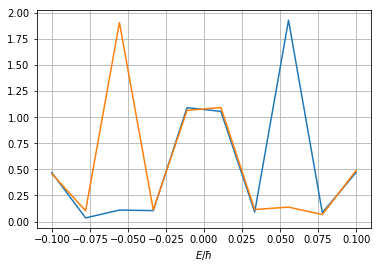

In [176]:
plt.figure()
plt.plot(Esw/hwc,Reh)
plt.plot(Esw/hwc,Ree)
plt.grid()
# plt.ylim(0,1.1)
plt.xlabel(r'$r_{eh}$')
plt.xlabel(r'$E/\hbar $')
plt.show()

In [136]:
m_sc=0*hwc
mu_sc=8*hwc
m_sc_lead=1000*hwc
mu_sc_lead=0*hwc

Esw= np.array([0.0])
mu_n_sw=np.linspace(0.24,1.0,20)*hwc

Ree=np.zeros(len(mu_n_sw))
Reh=np.zeros(len(mu_n_sw))

for i_m in range(len(mu_n_sw)):
    print(i_m,end='\r')

    mu_n= mu_n_sw[i_m]
    num_refl,Revecs_l,Tevecs_l= sample_modes(m_sc_lead,mu_sc_lead,mu_n,Esw,Nx,Lx,Ls,'lead')
    Tevecs= sample_modes(m_sc,mu_sc,mu_n,Esw,Nx,Lx,Ls,'sample')

    Psi_t=np.concatenate((-Revecs_l,Tevecs),axis=1)
    x=sp.linalg.solve(Psi_t,Tevecs_l)
    
    if x.shape[1]>1:
        Ree[i_m] = np.sum(np.sum(np.abs(x[:num_refl[0],:])**2,axis=0),axis=1)
        Reh[i_m] = np.sum(np.sum(np.abs(x[num_refl[0]:num_refl[1],:])**2,axis=0),axis=1)
    else:
        Ree[i_m] = np.sum(np.abs(x[:num_refl[0]])**2,axis=0)
        Reh[i_m] = np.sum(np.abs(x[num_refl[0]:num_refl[1]])**2,axis=0)

print('Done!')


ValueError: Input a needs to be a square matrix.

In [144]:
print(Revecs_l.shape)

(1600, 802)


KeyboardInterrupt: 

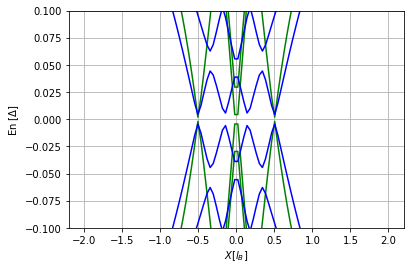

In [82]:

plt.figure()
plt.plot(ky_sw*lB,Ek0.T/hwc,'g')
# Eps_lead=np.kron(np.ones(len(kps_lead)),Esw)
# Ens_lead=np.kron(np.ones(len(kns_lead)),Esw)
# plt.plot(kps_lead,Eps_lead/hwc,'go')
# plt.plot(kns_lead,Ens_lead/hwc,'gv')

plt.plot(ky_sw*lB,Ek.T/hwc,'b')
# Eps=np.kron(np.ones(len(kps)),Esw)
# Ens=np.kron(np.ones(len(kns)),Esw)
# plt.plot(kps,Eps/hwc,'bo')
# plt.plot(kns,Ens/hwc,'bv')

plt.ylabel(r"En [$\Delta$]")
plt.xlabel(r"$X[l_B]$")
# plt.ylim(-22,22)
# plt.ylim(-0.015,0.015)
plt.ylim(-0.1,0.1)
plt.grid()
# print(kps_lead)

Comparison with Andreev Edge state

In [ ]:
t_timer=time.time()

x0_kmin=1.8#-1.50

# Ls_sw=np.linspace(2,10,40)*lB
# Ls_sw=np.arange(2,11)*lB
Ls_sw=np.array([6])*lB
Nx2=200

# kmin=x0_kmin-0.2
# kmax=x0_kmin+0.2
# ky_sw=np.linspace(kmin,kmax,80)
ky_sw=np.linspace(0,3,40)#*2.0*np.sign(x0_kmin)
Ek2= np.zeros((len(ky_sw),len(Ls_sw)))
Eg_mat= np.zeros(len(Ls_sw))

Vp= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
Vh= np.zeros((2,len(Ls_sw)), dtype=np.complex64)
kpt=np.zeros(len(Ls_sw))
for i_L in range(len(Ls_sw)):
    print(i_L, end='\r')
    Ls=Ls_sw[i_L]
    U2=0*hwc

#     f2=minimize(system_E_vs_k,x0=x0_kmin,args=(Nx2,U2,Ls))
#     kx2,Em,Vm= system_builder(f2.x[0],Nx=Nx2,U0=U2,Ls=Ls)
#     kpt[i_L]=f2.x[0]
#     Eg_mat[i_L]=f2.fun
    Ek2[:,i_L]=system_E_vs_k(k0=ky_sw,Nx=Nx2,U0=0,Ls=Ls)

    
elapsed = time.time() - t_timer
print("Finished, elapsed time = %.0f " % (elapsed)+ "sec")

In [ ]:
def plot_bands(i_L):
    pyplot.figure()
    pyplot.plot(ky_sw,Ek2[:,i_L],'b')
    pyplot.plot(kpt[i_L],Eg_mat[i_L],'ro')
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
    pyplot.ylabel("Energy(meV)")
    pyplot.xlabel("X(l)")
    pyplot.show()

interact(plot_bands, i_L=(0,len(Ls_sw)-1,1));

In [ ]:
pyplot.figure()
pyplot.plot(Ls_sw/lB,Eg_mat)
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.grid()
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$E_g$")
pyplot.show()

pyplot.figure()
pyplot.plot(Ls_sw/lB,kpt)
# pyplot.plot(Ls_sw/lB,Eb_mat.T/hwc)
pyplot.grid()
pyplot.xlabel(r"$L_{sc}/l_B$")
pyplot.ylabel(r"$k_0$")
pyplot.show()

# ratio=np.tan(abs(np.angle(Vp/Vh).T))**2
# pyplot.figure()
# # pyplot.plot(Ls_sw/lB,np.mod(np.angle(Vp/Vh).T/pi,1))
# pyplot.plot(Ls_sw/lB,np.abs(np.tan(theta)))
# # pyplot.plot(Ls_sw/lB,np.abs(Vp).T)
# # pyplot.plot(Ls_sw/lB,np.abs(Vh).T)
# # pyplot.plot(Ls_sw/lB,np.angle(Vp/Vh).T/pi)
# # pyplot.plot(Ls_sw/lB,ratio/(1+ratio))
# # pyplot.plot(Ls_sw/lB,Vh)
# pyplot.ylim([0.,0.1])
# pyplot.grid()
# pyplot.ylabel("p/h components")
# pyplot.xlabel(r"$k0*l_B$")
# pyplot.show()
# print(np.abs(theta/pi))

In [ ]:
# f1=minimize(system_E_vs_k,x0=0.8,args=(Nx1,U1,Ls1))
# kx1,Eb,Vb= system_builder(1.1*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
# wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)

def plot_wf(i_L):
    iwf=0
    pyplot.figure()
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf1_h_arr[:,i_L])**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_p_arr[:,iwf,i_L])**2/2)
    pyplot.plot(x0/lB,np.abs(wf2_h_arr[:,iwf,i_L])**2/2)
#     pyplot.plot(x0/lB,np.real(wf2_p_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.imag(wf2_p_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.real(wf2_h_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.imag(wf2_h_arr[:,iwf,i_L]))
#     pyplot.plot(x0/lB,np.abs(wf2_h_arr[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
    pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
#     pyplot.ylim([0,0.01])
    pyplot.show()
    
interact(plot_wf, i_L=(0,len(Ls_sw)-1,1));

In [ ]:
Nx1=100
U1=100*hwc
Ls1=20*lB
# x0_kmin=[0.3,0.9,1.50,2.2]
x0=np.linspace(-1,1,1000)*20*lB


def plot_wf(i_L,x0_kmin):
    f1=minimize(system_E_vs_k,x0=x0_kmin,args=(Nx1,U1,Ls1))
    print(f1.x[0])
    kx1,Eb,Vb= system_builder((1.+0.1*np.sign(f1.x[0]))*f1.x[0],Nx=Nx1,U0=U1,Ls=Ls1)
    wf1_p,wf1_h=wf_real_space(Vb,kx1,x0,Ls1)
    print(np.linalg.norm(wf1_p))
    
    iwf=0
    pyplot.figure()
    pyplot.plot(x0/lB,np.abs(wf1_p[:,iwf])**2/2)
    pyplot.plot(x0/lB,np.abs(wf1_h[:,iwf])**2/2)
#     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_p[:,iwf,i_L])**2)
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.abs(wf2_h[:,iwf,i_L])**2)
#     pyplot.plot(x0/lB,np.real(wf1_p))
#     pyplot.plot(x0/lB,np.imag(wf1_p))
# #     pyplot.plot(x0/lB,np.real(wf2_p[:,iwf,i_L]))
# #     pyplot.plot(x0/lB,np.abs(wf1_h)**2/2)
#     pyplot.plot(x0/lB,np.imag(wf2_p[:,iwf,i_L]))
#     pyplot.title('L=%.2f' % (Ls_sw[i_L]/lB) )
#     pyplot.ylim([0,0.004])
    pyplot.show()
    
# interact(plot_wf, i_L=(0,len(Ls_sw)-1,1), x0_kmin=[0.3,0.9,1.50,2.2]);
# interact(plot_wf, i_L=(0,len(Ls_sw)-1,1), x0_kmin=[0.5,1.2]);

In [ ]:
plot_wf(i_L=0,x0_kmin=0.5)